# 05. Random labels

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    benchmark_ind = [21, 276, 1397, 1409, 257, 537, 83, 96, 94, 247] # ths one grants 70% accuracy
    
C = Const()

In [12]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [13]:
# Collect limited datasets

def find_data(ytrain, nrows):
    hist = [0]*10
    indices = np.zeros((nrows, 10), dtype=int)
    i = 0
    while min(hist) < nrows:
        label = np.argmax(ytrain[i])
        if hist[label]<nrows:
            indices[hist[label], label] = i
            hist[label] += 1
        i += 1
    return indices
    
indices = find_data(ytrain, 20)
print(indices)

[[  1   3   5   7   2   0  13  15  17   4]
 [ 21   6  16  10   9  11  18  29  31  19]
 [ 34   8  25  12  20  35  32  38  41  22]
 [ 37  14  28  27  26  47  36  42  46  33]
 [ 51  23  76  30  53  65  39  52  55  43]
 [ 56  24  82  44  58 100  62  71  85  45]
 [ 63  40 109  49  60 132  66  79  94  48]
 [ 68  59 117  50  61 138  73  84  97  54]
 [ 69  67 120  74  64 145  83  91 125  57]
 [ 75  70 122  86  89 173  90  96 137  80]
 [ 81  72 143  98  92 175  93 101 144  87]
 [ 88  77 159 107 115 182 106 103 146 110]
 [ 95  78 161 111 127 191 126 123 160 116]
 [108  99 171 130 131 219 129 140 188 133]
 [114 102 178 135 139 236 147 141 197 153]
 [118 104 180 136 142 239 151 148 202 154]
 [119 105 187 149 150 244 155 158 225 162]
 [121 112 189 157 163 259 165 168 240 167]
 [156 113 190 179 164 266 186 185 245 170]
 [169 124 199 181 166 273 204 193 265 172]]


In [14]:
def _compile_model(model):
    """Helper function, just to not write this out every time."""
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])    
    return model

def build_model():
    """Build a naive model, then compile."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    return _compile_model(model)

def reset_last_layer(model):
    """Reset last layer (actually copy all except the last layer)."""
    model2 = tf.keras.Sequential()
    for layer in model.layers[:-1]: # Copy from input model
        model2.add(layer)
    model2.add(tf.keras.layers.Dense(C.nclasses, activation='softmax')) # Last layer
    for layer in model2.layers[:-1]:
        layer.trainable = False
    return _compile_model(model2)

model = build_model()
#model.summary()

In [15]:
class PrintDot(tf.keras.callbacks.Callback):
    """Helper function to report running loss during training."""
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

In [16]:
def train_model(model, x, y, epochs=40):
    hist = model.fit(x, y,
                      batch_size=1024,
                      epochs=40,
                      verbose=0,
                      validation_data=(xtest, ytest)) # Note that it's not validation, but rather test data

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    score = model.evaluate(xtest, ytest, verbose=0)
    return score[1]

## Pre-training (tran full network on partial data)

Accuracy: 
0.5643
0.462
0.4188
0.5318
0.4293
0.433
0.4282
0.47
0.4724
0.419
0.5319
0.6351
0.4955
0.5184
0.4979
0.4311
0.4968
0.4553
0.5442
0.4382


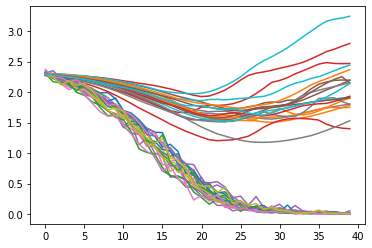

In [9]:
# No pre-training: just overfit a naive network with partial data:

print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]])
    print(acc)

Accuracy: 
0.4229
0.3211
0.3311
0.4665
0.3719
0.3419
0.3615
0.4443
0.4238
0.3675
0.4539
0.2973
0.3458
0.3492
0.3091
0.3644
0.4205
0.3662
0.4531
0.3766


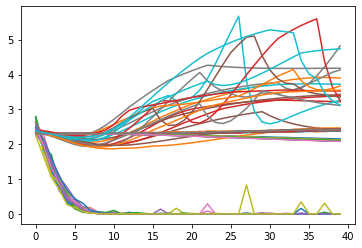

In [10]:
# Pretrain on random labels, then train again on a limited sample:
print('Accuracy: ')
for i in range(indices.shape[0]):
    randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
    model = build_model()    
    train_model(model, xtrain, ytrain[randints], epochs=300)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.9873
0.9872
0.9687
0.9462
0.9817
0.9446
0.9773
0.9177
0.9629
0.9662
0.978
0.9704
0.9771
0.9491
0.9472
0.9567
0.9571
0.9704
0.9657
0.9514


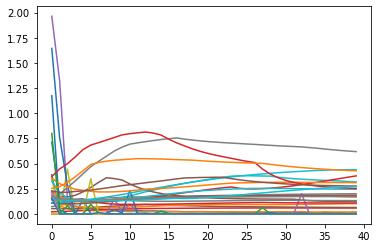

In [12]:
# Train on a full dataset, then rather stupidly train again on a limited sample:
print('Accuracy: ')
model = build_model()   
train_model(model, xtrain, ytrain, epochs=300)
for i in range(indices.shape[0]):
    model2 = tf.keras.Sequential()
    for layer in model.layers: # Copy all layers
        model2.add(layer)
    model2 = _compile_model(model2)
    acc = train_model(model2, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

## Embeddings (only train last layer)

Accuracy: 
0.1157
0.0884
0.0688
0.095
0.127
0.1606
0.1104
0.1246
0.1085
0.085
0.1073
0.1589
0.1196
0.1303
0.0949
0.0938
0.0881
0.1279
0.1106
0.0899


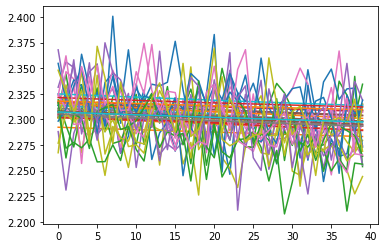

In [22]:
# Randomize all layers, but only train last layer (aka no pre-training, aka random embedding)
print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    model = reset_last_layer(model)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.1071
0.1217
0.1723
0.1035
0.1351
0.1095
0.0608
0.1243
0.1206
0.1002
0.1751
0.1687
0.1167
0.1175
0.1242
0.0916
0.1181
0.1653
0.1376
0.0971


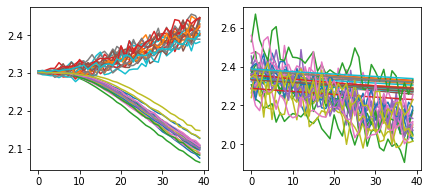

In [17]:
# Embedding on random labels:
print('Accuracy: ')
plt.figure(figsize=(7,3))
ax = [plt.subplot(1,2,i) for i in [1,2]]
for i in range(indices.shape[0]):
    randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
    model = build_model()
    plt.sca(ax[0])
    train_model(model, xtrain, ytrain[randints], epochs=300)
    model = reset_last_layer(model)
    plt.sca(ax[1])
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.2752
0.3299
0.2678
0.2537
0.244
0.2486
0.1699
0.0951
0.3365
0.4516
0.1985
0.2919
0.16
0.292
0.3321
0.1722
0.3119
0.307
0.3893
0.3674


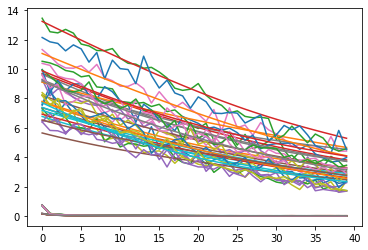

In [8]:
# Pre-training on full data, then retrain the last layer (aka presumably-ideal embedding)
print('Accuracy: ')
plt.figure(figsize=(7,3))
for i in range(indices.shape[0]):
    model = build_model()
    plt.subplot(121)
    acc = train_model(model, xtrain, ytrain, epochs=300)
    model = reset_last_layer(model)
    plt.subplot(122)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)